# IMPETUS – Exploratory Data Analysis (EDA) Temporale

**Modulo**: Analisi Esplorativa Dati Grezzi  
**Obiettivo**: Comprendere pattern, distribuzioni e relazioni nei dati prima di creare feature  
**Approccio**: Visuale e statistico  

---

## Domande di Ricerca (EDA)

1. **Distribuzione**: Come sono distribuiti load, RPE, volume? Ci sono outlier?
2. **Temporalità**: Esistono trend temporali? Progressive overload visibile?
3. **Correlazioni**: Quali variabili sono correlate? Load ↔ RPE? Volume ↔ Fatigue?
4. **Differenze per Livello**: Beginner vs Advanced: gap quantificabile?
5. **Banister**: Fitness/Fatigue/Performance seguono dinamica attesa?
6. **Spike**: Eventi di sovraccarico acuto sono rilevabili visualmente?
7. **Missing Data**: Pattern nei dati mancanti (es. RPE non registrato)?

---

## Output Attesi

- Grafici interpretativi con annotazioni
- Statistiche descrittive per gruppo
- Identificazione feature candidate per engineering
- Validazione assunzioni del generatore sintetico

---

## Setup


## **CELLA 2 - Setup Environment**

In [ ]:
# Import librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Stile visualizzazioni
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Palette colori per experience level (consistency con STATUS)
EXPERIENCE_COLORS = {
    'Beginner': '#2ecc71',
    'Intermediate': '#3498db',
    'Advanced': '#e74c3c'
}

print("(OK) Environment pronto per EDA")


(OK) Environment pronto per EDA


## **CELLA 3 - Caricamento Dati**

In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 1: CARICAMENTO E VALIDAZIONE DATI GREZZI
# ═══════════════════════════════════════════════════════════════

print("=" * 80)
print("CARICAMENTO DATASET")
print("=" * 80)

# Carica CSV (modifica PATH se necessario)
PATH = './'

workout_sets = pd.read_csv('workout_sets.csv')
sessions = pd.read_csv('sessions.csv')
banister = pd.read_csv('banister_daily.csv')
workouts = pd.read_csv('workouts.csv')
users = pd.read_csv('users.csv')
exercises = pd.read_csv('exercises.csv')

# Parse date
for df in [workout_sets, banister, workouts, sessions]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

# Merge experience_label (chiave per analisi)
workout_sets = workout_sets.merge(
    users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

print(f"\n(OK) Dataset caricati:")
datasets_info = pd.DataFrame({
    'Dataset': ['workout_sets', 'sessions', 'banister_daily', 'workouts', 'users', 'exercises'],
    'Righe': [len(workout_sets), len(sessions), len(banister), len(workouts), len(users), len(exercises)],
    'Colonne': [len(workout_sets.columns), len(sessions.columns), len(banister.columns),
                len(workouts.columns), len(users.columns), len(exercises.columns)]
})
print(datasets_info.to_string(index=False))

# Range temporale
print(f"\nRange temporale:")
print(f"   {workout_sets['date'].min().date()} → {workout_sets['date'].max().date()}")
print(f"   Span: {(workout_sets['date'].max() - workout_sets['date'].min()).days} giorni")


CARICAMENTO DATASET

(OK) Dataset caricati:
       Dataset  Righe  Colonne
  workout_sets 449630       17
      sessions  41621        8
banister_daily 107707       10
      workouts  47332       10
         users   1000       16
     exercises     12        8

Range temporale:
   2025-02-04 → 2026-02-01
   Span: 362 giorni


## **CELLA 4 - Validazioni Integrità (con Visual Check)**


VALIDAZIONE INTEGRITÀ DATI

(OK) Check 1: Set su sessioni skipped
   PASS: Nessun set su workout skipped (integrity OK)

Missing Values:
         Colonna  Missing  Missing %
        feedback   427610      95.10
    load_done_kg     4470       0.99
     reps_target        1       0.00
load_intended_kg        1       0.00
       reps_done        1       0.00
        rpe_done        1       0.00
rest_planned_sec        1       0.00
      rir_target        1       0.00
       workoutid        1       0.00


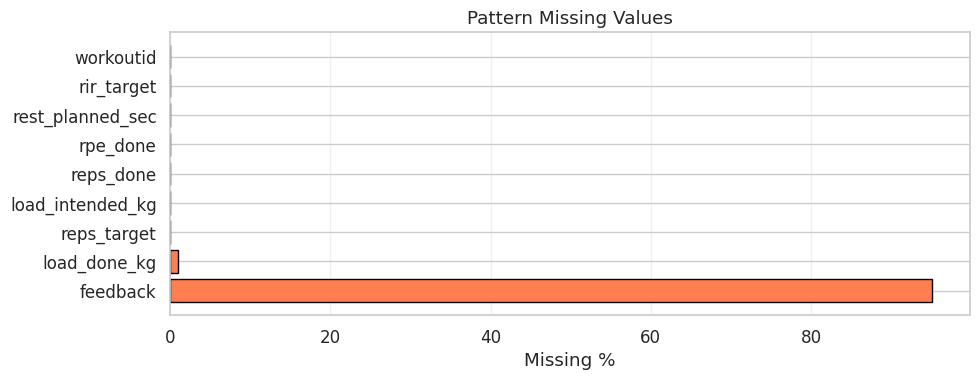


Distribuzione Experience Level:
   Advanced    : 46,575 set ( 10.4%) █████
   Beginner    : 154,058 set ( 34.3%) █████████████████
   Intermediate: 248,997 set ( 55.4%) ███████████████████████████


In [ ]:
# ═══════════════════════════════════════════════════════════════
# VALIDAZIONE INTEGRITÀ (con grafici)
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("VALIDAZIONE INTEGRITÀ DATI")
print("=" * 80)

# Check 1: Set su sessioni skipped (DEVE essere 0)
merged_check = workout_sets.merge(workouts[['workoutid', 'workout_status']], on='workoutid')
skipped_leak = merged_check[merged_check['workout_status'] == 'skipped']

print(f"\n(OK) Check 1: Set su sessioni skipped")
if len(skipped_leak) == 0:
    print(f"   PASS: Nessun set su workout skipped (integrity OK)")
else:
    print(f"   (!) FAIL: {len(skipped_leak)} set trovati su skipped!")

# Check 2: Missing values (visualizza pattern)
missing_summary = pd.DataFrame({
    'Colonna': workout_sets.columns,
    'Missing': workout_sets.isna().sum(),
    'Missing %': (workout_sets.isna().sum() / len(workout_sets) * 100).round(2)
}).query('Missing > 0').sort_values('Missing', ascending=False)

print(f"\nMissing Values:")
if len(missing_summary) > 0:
    print(missing_summary.to_string(index=False))

    # Grafico missing pattern
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.barh(missing_summary['Colonna'], missing_summary['Missing %'], color='coral', edgecolor='black')
    ax.set_xlabel('Missing %')
    ax.set_title('Pattern Missing Values')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("   (OK) Nessun missing value")

# Check 3: Distribuzione experience_label
exp_dist = workout_sets['experience_label'].value_counts().sort_index()
print(f"\nDistribuzione Experience Level:")
for level, count in exp_dist.items():
    pct = count / len(workout_sets) * 100
    bar = '█' * int(pct / 2)
    print(f"   {level:12s}: {count:6,} set ({pct:5.1f}%) {bar}")


## **CELLA 5 - Analisi Univariata: Load, RPE, Reps**


ANALISI UNIVARIATA: DISTRIBUZIONI

Statistiche Descrittive:
                 count   mean    std   min    25%    50%   75%     max
load_done_kg  445160.0  42.71  17.08  9.75  29.75  40.25  52.5  178.25
reps_done     449629.0   9.05   3.59  1.00   6.00   9.00  12.0   23.00
rpe_done      449629.0   4.46   0.74  1.00   4.00   4.50   5.0    8.00


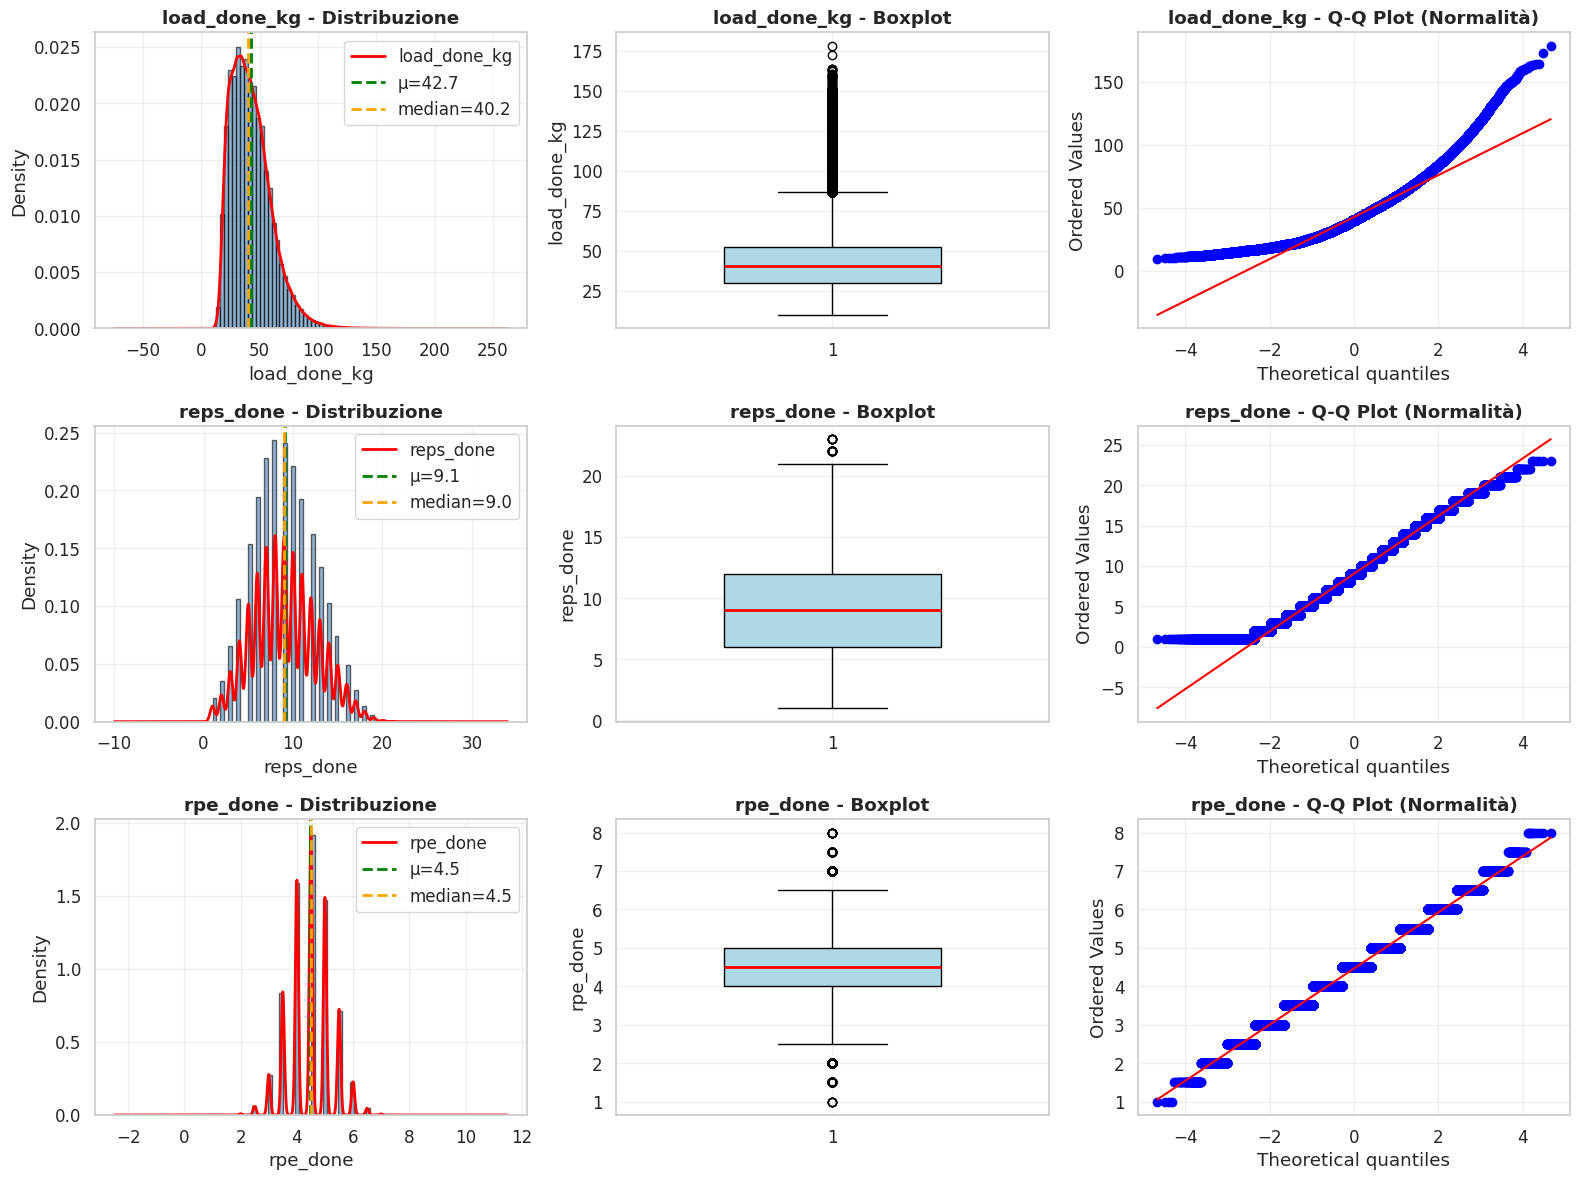


Test Normalità (Shapiro-Wilk, sample=5000):
   load_done_kg   : p-value=0.0000 → (!) Non normale
   reps_done      : p-value=0.0000 → (!) Non normale
   rpe_done       : p-value=0.0000 → (!) Non normale


In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 2: ANALISI UNIVARIATA - DISTRIBUZIONI BASE
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("ANALISI UNIVARIATA: DISTRIBUZIONI")
print("=" * 80)

# Statistiche descrittive
features_base = ['load_done_kg', 'reps_done', 'rpe_done']
desc_stats = workout_sets[features_base].describe().T

print("\nStatistiche Descrittive:")
print(desc_stats.round(2).to_string())

# Visualizzazione: Istogrammi + KDE + Boxplot
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, col in enumerate(features_base):
    data = workout_sets[col].dropna()

    # Colonna 1: Istogramma + KDE
    ax1 = axes[i, 0]
    ax1.hist(data, bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)
    data.plot.kde(ax=ax1, color='red', linewidth=2)
    ax1.axvline(data.mean(), color='green', linestyle='--', linewidth=2, label=f'μ={data.mean():.1f}')
    ax1.axvline(data.median(), color='orange', linestyle='--', linewidth=2, label=f'median={data.median():.1f}')
    ax1.set_title(f'{col} - Distribuzione', fontweight='bold')
    ax1.set_xlabel(col)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Colonna 2: Boxplot
    ax2 = axes[i, 1]
    bp = ax2.boxplot(data, vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['medians'][0].set_color('red')
    bp['medians'][0].set_linewidth(2)
    ax2.set_title(f'{col} - Boxplot', fontweight='bold')
    ax2.set_ylabel(col)
    ax2.grid(alpha=0.3)

    # Colonna 3: Q-Q Plot (normalità)
    ax3 = axes[i, 2]
    stats.probplot(data, dist="norm", plot=ax3)
    ax3.set_title(f'{col} - Q-Q Plot (Normalità)', fontweight='bold')
    ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test normalità (Shapiro-Wilk su sample per velocità)
print("\nTest Normalità (Shapiro-Wilk, sample=5000):")
for col in features_base:
    sample = workout_sets[col].dropna().sample(min(5000, len(workout_sets)), random_state=42)
    stat, p = stats.shapiro(sample)
    is_normal = "(OK) Normale" if p > 0.05 else "(!) Non normale"
    print(f"   {col:15s}: p-value={p:.4f} → {is_normal}")


## **CELLA 6 - Analisi Bivariata: Correlazioni**


ANALISI BIVARIATA: CORRELAZIONI

Matrice Correlazione:
              load_done_kg  reps_done  rpe_done  set_index
load_done_kg         1.000     -0.366     0.122      0.076
reps_done           -0.366      1.000    -0.168     -0.145
rpe_done             0.122     -0.168     1.000      0.026
set_index            0.076     -0.145     0.026      1.000


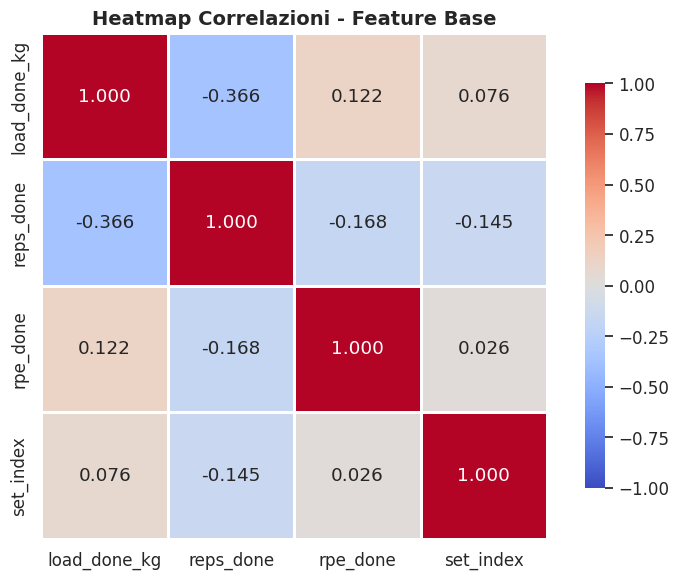


Pairplot (sample 10k set per velocità)...


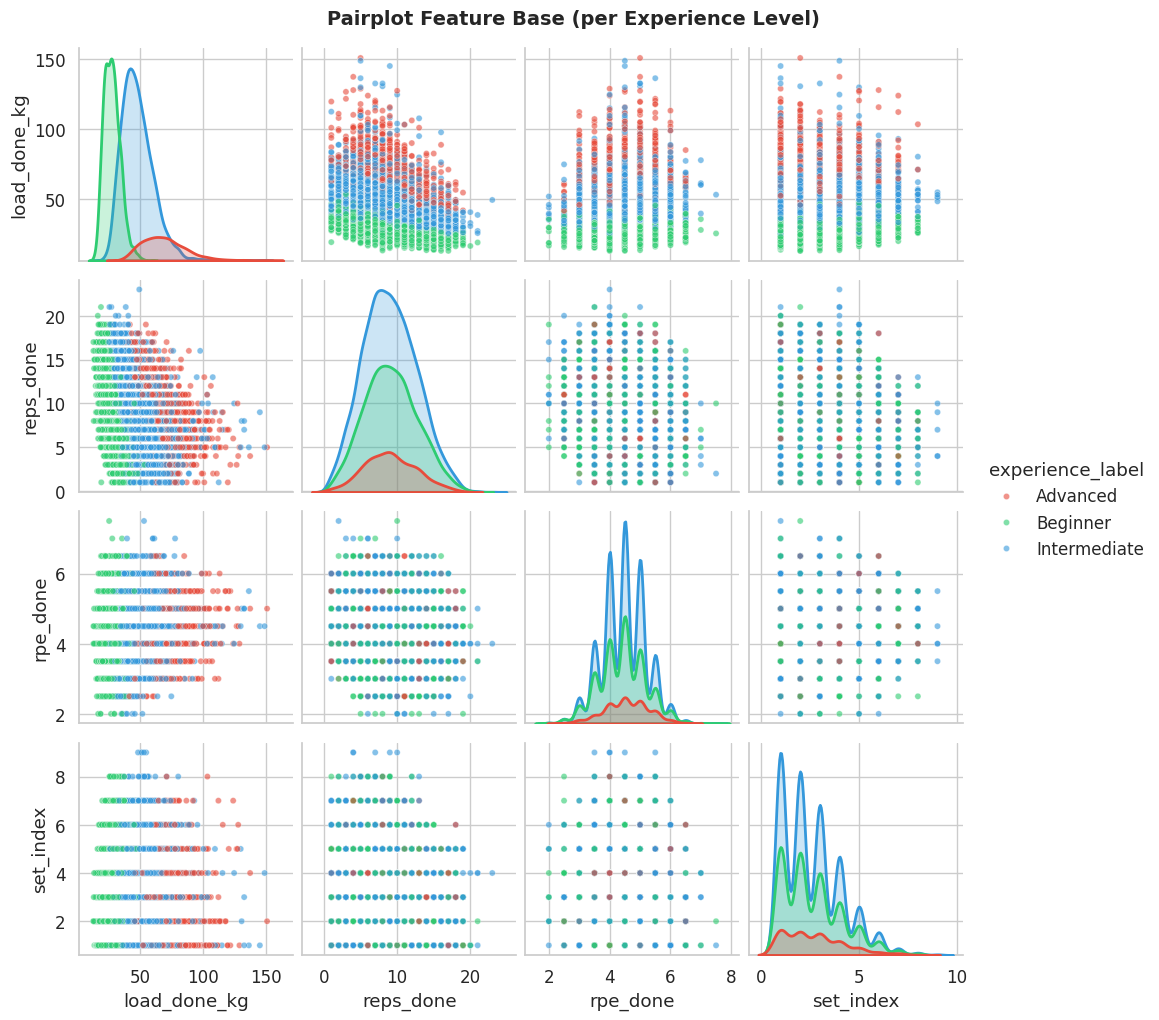

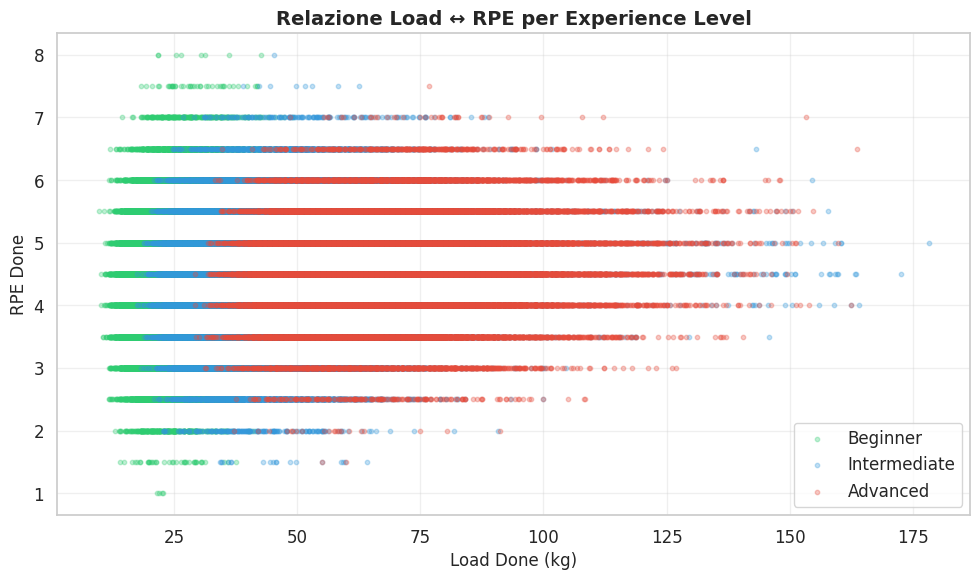


INSIGHT:
   - Correlazione load-RPE: 0.122
   → Load e RPE sono INDIPENDENTI (bene: RPE cattura fatica, non solo carico)


In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 3: ANALISI BIVARIATA - CORRELAZIONI
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("ANALISI BIVARIATA: CORRELAZIONI")
print("=" * 80)

# Subset feature numeriche chiave
features_corr = ['load_done_kg', 'reps_done', 'rpe_done', 'set_index']
corr_data = workout_sets[features_corr].copy()

# Calcola matrice correlazione
corr_matrix = corr_data.corr()

print("\nMatrice Correlazione:")
print(corr_matrix.round(3).to_string())

# HEATMAP Correlazione
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Heatmap Correlazioni - Feature Base', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# PAIRPLOT (sample per velocità)
print("\nPairplot (sample 10k set per velocità)...")
sample_data = workout_sets[features_corr + ['experience_label']].dropna().sample(
    min(10000, len(workout_sets)), random_state=42
)

g = sns.pairplot(sample_data, hue='experience_label', palette=EXPERIENCE_COLORS,
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20},
                 diag_kws={'linewidth': 2})
g.fig.suptitle('Pairplot Feature Base (per Experience Level)', y=1.02, fontweight='bold', fontsize=14)
plt.show()

# Scatter plot specifico: Load vs RPE (mostra relazione attesa)
fig, ax = plt.subplots(figsize=(10, 6))
for level in ['Beginner', 'Intermediate', 'Advanced']:
    data = workout_sets[workout_sets['experience_label'] == level]
    ax.scatter(data['load_done_kg'], data['rpe_done'],
               alpha=0.3, s=10, label=level, color=EXPERIENCE_COLORS[level])

ax.set_xlabel('Load Done (kg)', fontsize=12)
ax.set_ylabel('RPE Done', fontsize=12)
ax.set_title('Relazione Load ↔ RPE per Experience Level', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretazione
print("\nINSIGHT:")
corr_load_rpe = corr_matrix.loc['load_done_kg', 'rpe_done']
print(f"   - Correlazione load-RPE: {corr_load_rpe:.3f}")
if abs(corr_load_rpe) < 0.3:
    print("   → Load e RPE sono INDIPENDENTI (bene: RPE cattura fatica, non solo carico)")
else:
    print("   → Load e RPE sono correlati (atteso: carichi alti = RPE alto)")


##**CELLA 7 - Analisi Temporale: Trend nel Tempo**


ANALISI TEMPORALE: TREND


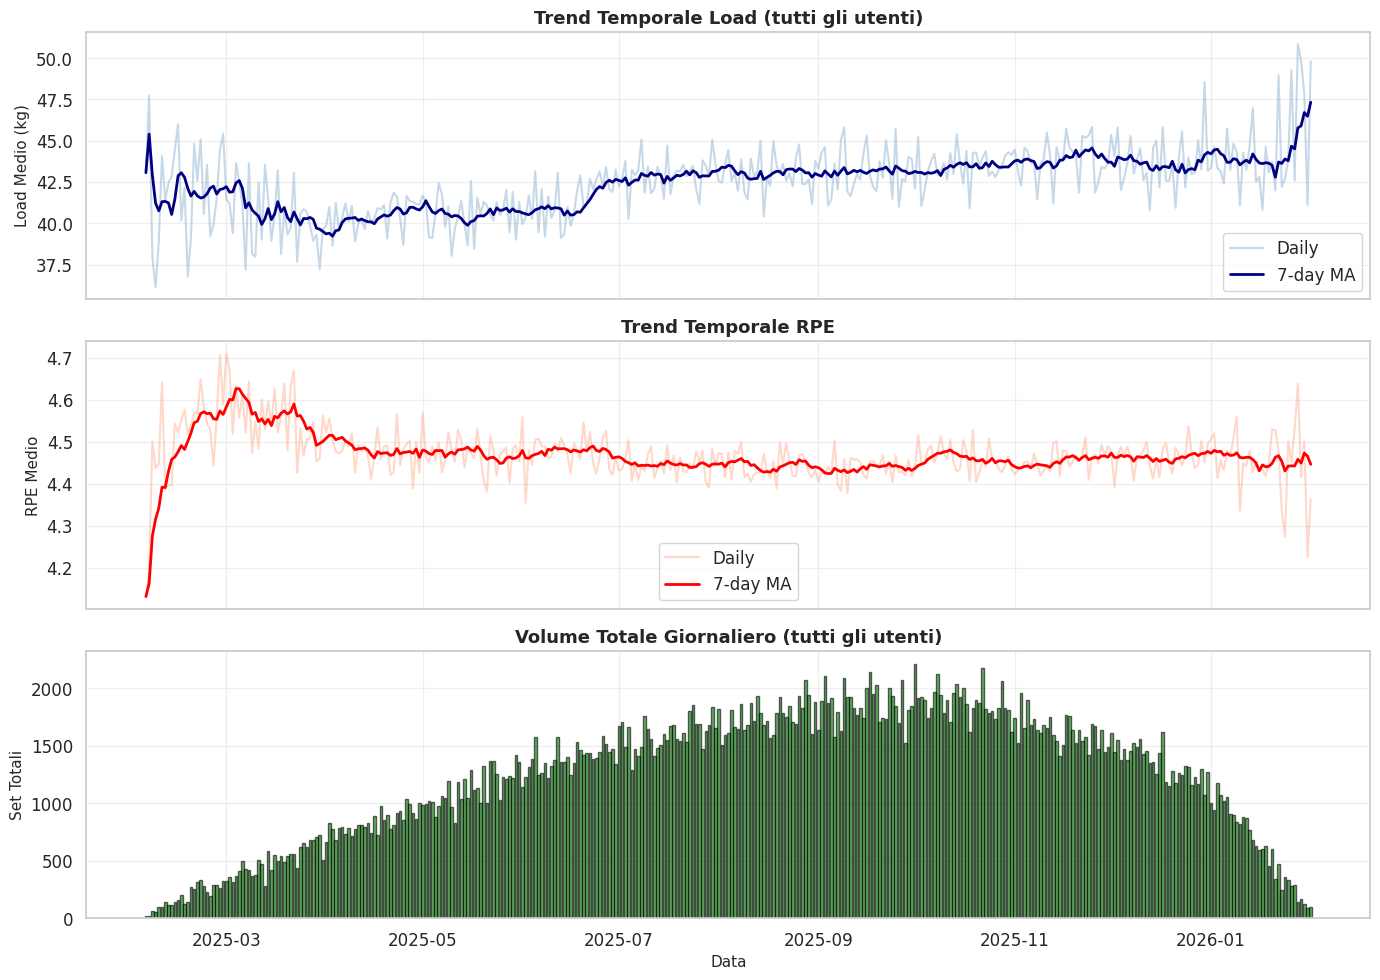


Progressive Overload Check (sample utente):


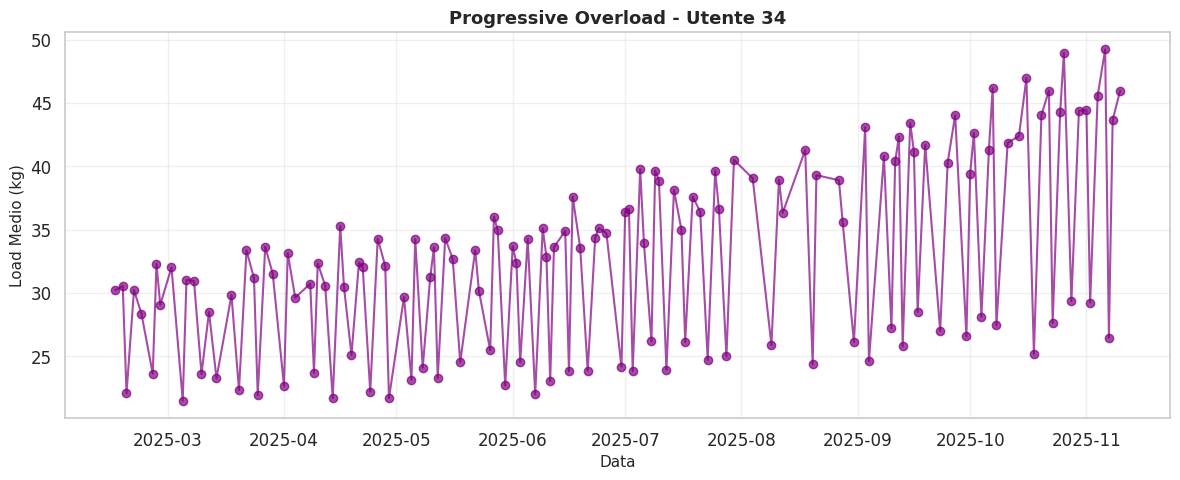


INSIGHT Progressive Overload:
   Slope globale load: 0.0113 kg/giorno
   (OK) Progressive overload rilevato (0.34 kg/mese)


In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 4: ANALISI TEMPORALE - TREND E PROGRESSIONE
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("ANALISI TEMPORALE: TREND")
print("=" * 80)

# Aggrega per giorno (media globale)
daily_agg = workout_sets.groupby('date').agg({
    'load_done_kg': 'mean',
    'rpe_done': 'mean',
    'reps_done': 'mean',
    'set_index': 'count'
}).reset_index()
daily_agg.columns = ['date', 'load_mean', 'rpe_mean', 'reps_mean', 'num_sets']

# Rolling mean 7d per smooth trend
daily_agg['load_7d'] = daily_agg['load_mean'].rolling(7, min_periods=1).mean()
daily_agg['rpe_7d'] = daily_agg['rpe_mean'].rolling(7, min_periods=1).mean()

# Plot serie temporali
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Load nel tempo
axes[0].plot(daily_agg['date'], daily_agg['load_mean'], alpha=0.3, color='steelblue', label='Daily')
axes[0].plot(daily_agg['date'], daily_agg['load_7d'], color='navy', linewidth=2, label='7-day MA')
axes[0].set_ylabel('Load Medio (kg)', fontsize=11)
axes[0].set_title('Trend Temporale Load (tutti gli utenti)', fontweight='bold', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# RPE nel tempo
axes[1].plot(daily_agg['date'], daily_agg['rpe_mean'], alpha=0.3, color='coral', label='Daily')
axes[1].plot(daily_agg['date'], daily_agg['rpe_7d'], color='red', linewidth=2, label='7-day MA')
axes[1].set_ylabel('RPE Medio', fontsize=11)
axes[1].set_title('Trend Temporale RPE', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Volume (set totali per giorno)
axes[2].bar(daily_agg['date'], daily_agg['num_sets'], alpha=0.6, color='green', edgecolor='black')
axes[2].set_ylabel('Set Totali', fontsize=11)
axes[2].set_xlabel('Data', fontsize=11)
axes[2].set_title('Volume Totale Giornaliero (tutti gli utenti)', fontweight='bold', fontsize=13)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Progressive overload check (per singolo utente sample)
print("\nProgressive Overload Check (sample utente):")
sample_user = workout_sets['userid'].value_counts().index[0]
user_data = workout_sets[workout_sets['userid'] == sample_user].copy()
user_data = user_data.sort_values('date')
user_daily = user_data.groupby('date')['load_done_kg'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(user_daily['date'], user_daily['load_done_kg'], marker='o', linestyle='-', color='purple', alpha=0.7)
ax.set_xlabel('Data', fontsize=11)
ax.set_ylabel('Load Medio (kg)', fontsize=11)
ax.set_title(f'Progressive Overload - Utente {sample_user}', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Slope linear regression (trend globale)
from sklearn.linear_model import LinearRegression
X_days = (daily_agg['date'] - daily_agg['date'].min()).dt.days.values.reshape(-1, 1)
y_load = daily_agg['load_7d'].values
model = LinearRegression().fit(X_days, y_load)
slope = model.coef_[0]

print(f"\nINSIGHT Progressive Overload:")
print(f"   Slope globale load: {slope:.4f} kg/giorno")
if slope > 0.01:
    print(f"   (OK) Progressive overload rilevato ({slope*30:.2f} kg/mese)")
elif slope < -0.01:
    print(f"   (!)  Trend negativo (detraining o deload period)")
else:
    print(f"   → Trend stabile (maintenance)")


##**CELLA 8 - Analisi per Livello Esperienza**


ANALISI PER LIVELLO ESPERIENZA

Statistiche per Experience Level:
                 load_done_kg               reps_done              rpe_done             
                         mean    std median      mean   std median     mean   std median
experience_label                                                                        
Advanced                68.52  16.89  66.75      8.92  3.52    9.0     4.57  0.72    4.5
Beginner                27.16   6.42  26.50      9.19  3.65    9.0     4.41  0.79    4.5
Intermediate            47.50  12.29  46.00      9.00  3.56    9.0     4.47  0.72    4.5


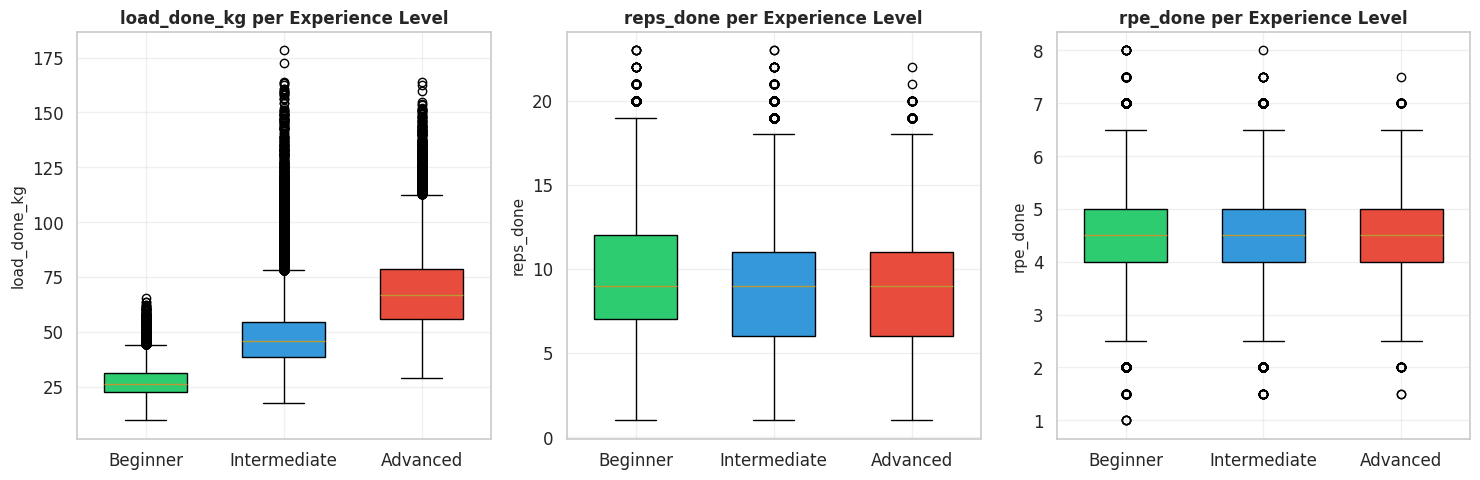

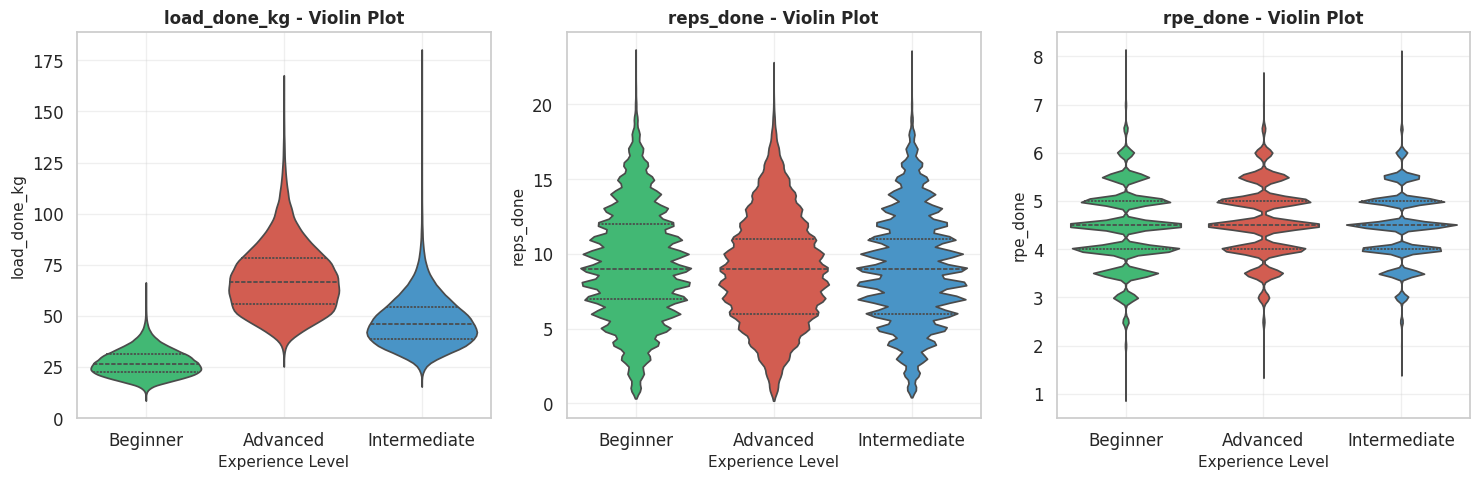


Test ANOVA (differenze tra livelli):
   load_done_kg   : F=287580.94, p=0.0000 → (OK) Significativo
   reps_done      : F=176.13, p=0.0000 → (OK) Significativo
   rpe_done       : F=874.38, p=0.0000 → (OK) Significativo

INSIGHT:
   - Load: Advanced sollevano MOLTO più di Beginner (atteso)
   - RPE: Differenze minori (RPE è soggettivo, può essere simile)
   - Reps: Variabilità cross-livello (dipende da schema)


In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 5: ANALISI PER LIVELLO ESPERIENZA
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("ANALISI PER LIVELLO ESPERIENZA")
print("=" * 80)

# Statistiche descrittive per gruppo
stats_by_level = workout_sets.groupby('experience_label')[features_base].agg(['mean', 'std', 'median'])

print("\nStatistiche per Experience Level:")
print(stats_by_level.round(2).to_string())

# BOXPLOT comparativo
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(features_base):
    ax = axes[i]

    # Dati per boxplot
    data_by_level = [
        workout_sets[workout_sets['experience_label'] == level][col].dropna()
        for level in ['Beginner', 'Intermediate', 'Advanced']
    ]

    bp = ax.boxplot(data_by_level, labels=['Beginner', 'Intermediate', 'Advanced'],
                    patch_artist=True, widths=0.6)

    # Colora boxes
    for patch, level in zip(bp['boxes'], ['Beginner', 'Intermediate', 'Advanced']):
        patch.set_facecolor(EXPERIENCE_COLORS[level])

    ax.set_title(f'{col} per Experience Level', fontweight='bold', fontsize=12)
    ax.set_ylabel(col, fontsize=11)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# VIOLINPLOT (mostra distribuzione completa)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(features_base):
    ax = axes[i]
    sns.violinplot(data=workout_sets, x='experience_label', y=col,
                   palette=EXPERIENCE_COLORS, ax=ax, inner='quartile')
    ax.set_title(f'{col} - Violin Plot', fontweight='bold', fontsize=12)
    ax.set_xlabel('Experience Level', fontsize=11)
    ax.set_ylabel(col, fontsize=11)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Test statistico (ANOVA): differenze significative?
print("\nTest ANOVA (differenze tra livelli):")
for col in features_base:
    groups = [workout_sets[workout_sets['experience_label'] == level][col].dropna()
              for level in ['Beginner', 'Intermediate', 'Advanced']]
    f_stat, p_value = stats.f_oneway(*groups)

    is_sig = "(OK) Significativo" if p_value < 0.05 else "❌ Non significativo"
    print(f"   {col:15s}: F={f_stat:.2f}, p={p_value:.4f} → {is_sig}")

print("\nINSIGHT:")
print("   - Load: Advanced sollevano MOLTO più di Beginner (atteso)")
print("   - RPE: Differenze minori (RPE è soggettivo, può essere simile)")
print("   - Reps: Variabilità cross-livello (dipende da schema)")


##**CELLA 9 - Analisi Banister (Fitness/Fatigue/TSB)**

In [ ]:
# ═══════════════════════════════════════════════════════════════
# FIX COMPLETO: Rimuovi duplicati + Setup Banister
# ═══════════════════════════════════════════════════════════════

print("=" * 80)
print("FIX BANISTER - CLEANUP DUPLICATI")
print("=" * 80)

# STEP 1: Ricarica banister pulito (evita duplicazioni da esecuzioni multiple)
print("\nRicaricamento banister_daily.csv...")
banister = pd.read_csv('./banister_daily.csv')
banister['date'] = pd.to_datetime(banister['date'])

print(f"(OK) Ricaricato: {len(banister)} righe")

# STEP 2: Rinomina F/D/P → fitness/fatigue/performance
banister = banister.rename(columns={
    'F': 'fitness',
    'D': 'fatigue',
    'P': 'performance'
})

print(f"\n(OK) Colonne rinominate (F→fitness, D→fatigue, P→performance)")

# STEP 3: Merge experience_label (solo se non già presente)
if 'experience_label' not in banister.columns:
    banister = banister.merge(
        users[['userid', 'experience_label']],
        on='userid',
        how='left'
    )
    print(f"(OK) Experience_label aggiunto")
else:
    print(f"(OK) Experience_label già presente")

# STEP 4: Calcola TSB
banister['TSB'] = banister['fitness'] - banister['fatigue']

print(f"(OK) TSB calcolato")

# STEP 5: Verifica schema finale
print(f"\nSchema finale banister:")
print(f"   Colonne ({len(banister.columns)}): {list(banister.columns)}")
print(f"   Righe: {len(banister):,}")

# Check duplicati
duplicates = banister.columns[banister.columns.duplicated()].tolist()
if duplicates:
    print(f"\n(!)  WARNING: Colonne ancora duplicate: {duplicates}")
else:
    print(f"\n(OK) Nessun duplicato")

# Preview
print(f"\nPrime 3 righe:")
print(banister[['userid', 'date', 'fitness', 'fatigue', 'performance', 'TSB', 'experience_label']].head(3).to_string())

print("\n" + "=" * 80)
print("(OK) BANISTER CLEANUP COMPLETATO")
print("=" * 80)


FIX BANISTER - CLEANUP DUPLICATI

Ricaricamento banister_daily.csv...
(OK) Ricaricato: 107707 righe

(OK) Colonne rinominate (F→fitness, D→fatigue, P→performance)
(OK) Experience_label aggiunto
(OK) TSB calcolato

Schema finale banister:
   Colonne (12): ['userid', 'date', 'impulse', 'fitness', 'fatigue', 'performance', 'tauF', 'tauD', 'betaF', 'betaD', 'experience_label', 'TSB']
   Righe: 107,707

(OK) Nessun duplicato

Prime 3 righe:
   userid       date  fitness  fatigue  performance  TSB experience_label
0       1 2025-08-09      0.0      0.0          0.0  0.0         Beginner
1       1 2025-08-10      0.0      0.0          0.0  0.0         Beginner
2       1 2025-08-11      0.0      0.0          0.0  0.0         Beginner

(OK) BANISTER CLEANUP COMPLETATO



ANALISI BANISTER DYNAMICS

Statistiche Banister:
         fitness    fatigue  performance        TSB    impulse
count  107707.00  107707.00    107707.00  107707.00  107707.00
mean    24833.08    5806.88       161.23   19026.20     827.41
std     18700.14    4001.52       146.50   15863.08    1237.69
min         0.00       0.00       -56.43       0.00       0.00
25%     11279.99    2956.05        52.97    7344.82       0.00
50%     20459.37    4878.96       129.26   15386.01       0.00
75%     33759.09    7707.80       229.11   26295.34    1576.39
max    175126.04   36018.01      1348.30  145064.62    9265.12


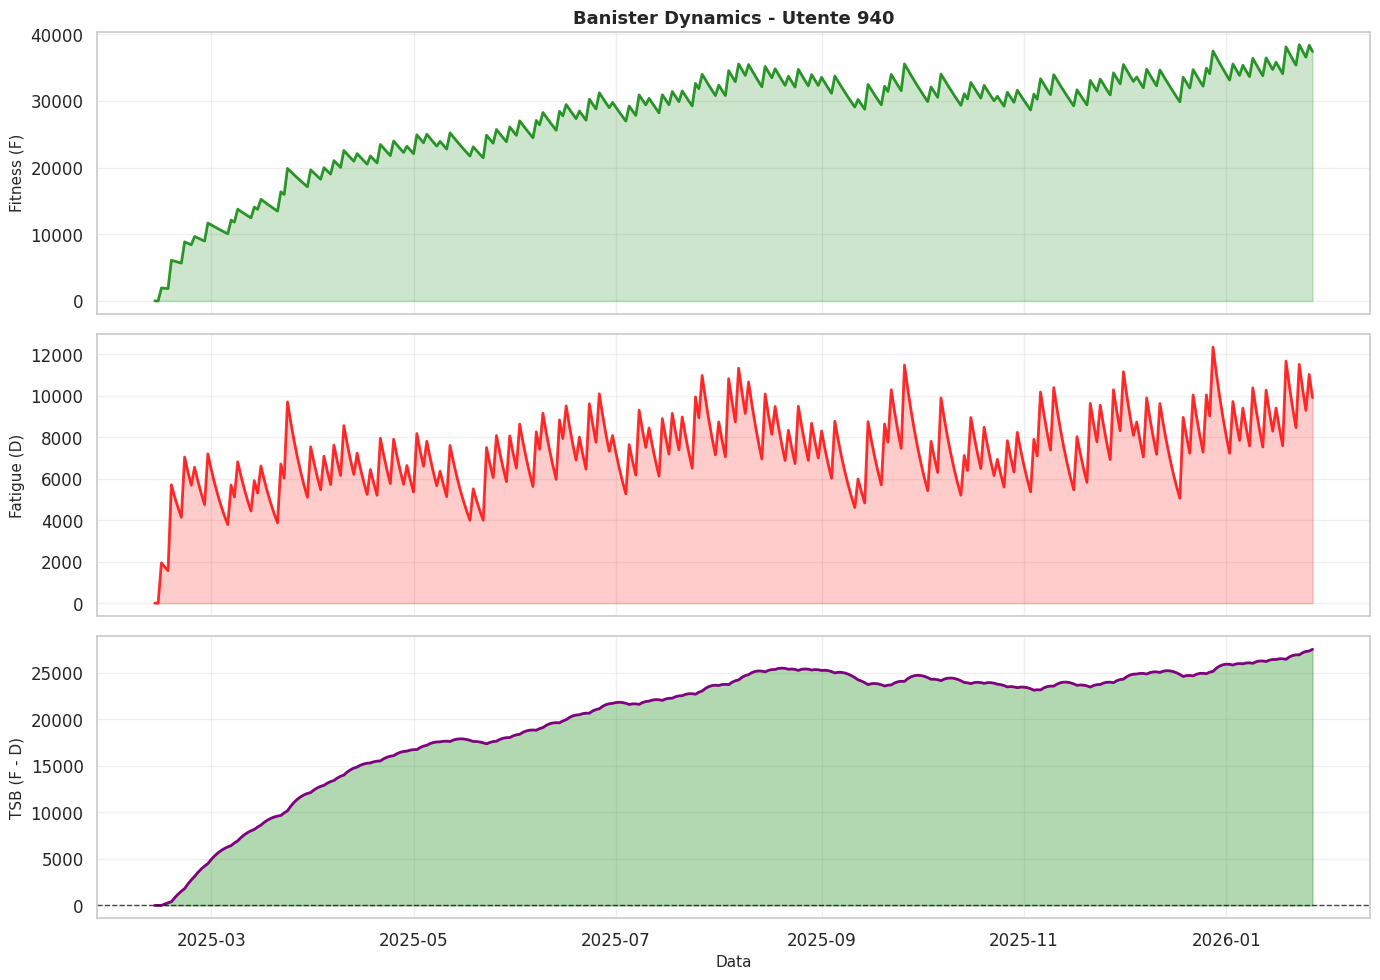

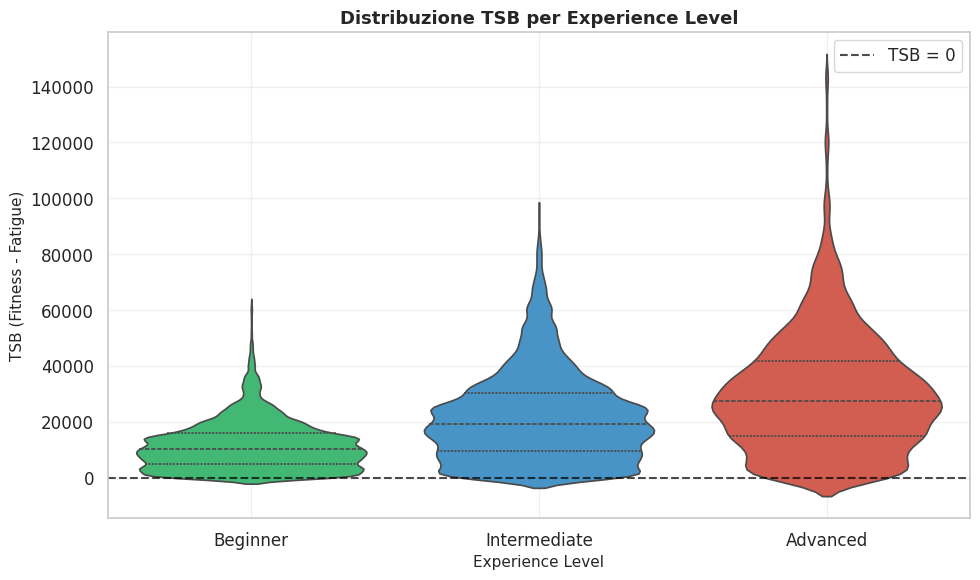


TSB per Experience Level:
                      mean       std  min        max    median
experience_label                                              
Advanced          30297.77  21310.17  0.0  145064.62  27586.78
Beginner          11521.87   8682.61  0.0   61929.82  10229.66
Intermediate      21816.93  16078.53  0.0   95060.09  19306.85

Calcolo correlazione Performance-Load (aggregazione settimanale)...


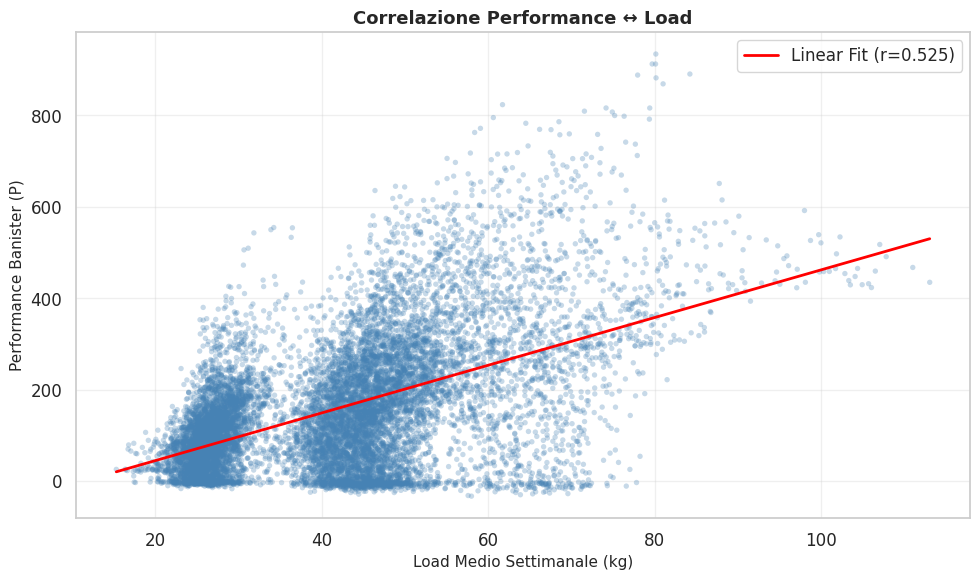


INSIGHT Banister:
   Correlazione Performance-Load: r = 0.525
   (OK) Correlazione moderata (dinamiche F/D bilanciate)
   Pearson test: r=0.525, p-value=0.0000
   (OK) Correlazione statisticamente significativa (p<0.001)

(OK) ANALISI BANISTER COMPLETATA


In [ ]:
# ═══════════════════════════════════════════════════════════════
# ANALISI BANISTER DYNAMICS (versione pulita)
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("ANALISI BANISTER DYNAMICS")
print("=" * 80)

# Statistiche descrittive
banister_stats = banister[['fitness', 'fatigue', 'performance', 'TSB', 'impulse']].describe()
print("\nStatistiche Banister:")
print(banister_stats.round(2).to_string())

# === PLOT 1: Serie temporali F/D/P per 1 utente ===
sample_user = banister['userid'].value_counts().index[0]
user_banister = banister[banister['userid'] == sample_user].sort_values('date')

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Fitness
axes[0].plot(user_banister['date'], user_banister['fitness'],
             color='green', linewidth=2, alpha=0.8)
axes[0].fill_between(user_banister['date'], user_banister['fitness'],
                      alpha=0.2, color='green')
axes[0].set_ylabel('Fitness (F)', fontsize=11)
axes[0].set_title(f'Banister Dynamics - Utente {sample_user}', fontweight='bold', fontsize=13)
axes[0].grid(alpha=0.3)

# Fatigue
axes[1].plot(user_banister['date'], user_banister['fatigue'],
             color='red', linewidth=2, alpha=0.8)
axes[1].fill_between(user_banister['date'], user_banister['fatigue'],
                      alpha=0.2, color='red')
axes[1].set_ylabel('Fatigue (D)', fontsize=11)
axes[1].grid(alpha=0.3)

# TSB (F - D)
axes[2].plot(user_banister['date'], user_banister['TSB'],
             color='purple', linewidth=2)
axes[2].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
axes[2].fill_between(user_banister['date'], 0, user_banister['TSB'],
                      where=(user_banister['TSB'] > 0), color='green', alpha=0.3)
axes[2].fill_between(user_banister['date'], 0, user_banister['TSB'],
                      where=(user_banister['TSB'] <= 0), color='red', alpha=0.3)
axes[2].set_ylabel('TSB (F - D)', fontsize=11)
axes[2].set_xlabel('Data', fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# === PLOT 2: Distribuzione TSB per livello ===
fig, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(data=banister, x='experience_label', y='TSB',
               order=['Beginner', 'Intermediate', 'Advanced'],
               palette=EXPERIENCE_COLORS, ax=ax, inner='quartile')
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='TSB = 0')
ax.set_title('Distribuzione TSB per Experience Level', fontweight='bold', fontsize=13)
ax.set_xlabel('Experience Level', fontsize=11)
ax.set_ylabel('TSB (Fitness - Fatigue)', fontsize=11)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiche TSB per livello
print("\nTSB per Experience Level:")
tsb_stats = banister.groupby('experience_label')['TSB'].agg(['mean', 'std', 'min', 'max', 'median'])
print(tsb_stats.round(2).to_string())

# === PLOT 3: Correlazione Performance vs Load ===
print("\nCalcolo correlazione Performance-Load (aggregazione settimanale)...")

# Aggrega per settimana
workout_sets['week_start'] = workout_sets['date'] - pd.to_timedelta(workout_sets['date'].dt.dayofweek, unit='d')
banister['week_start'] = banister['date'] - pd.to_timedelta(banister['date'].dt.dayofweek, unit='d')

weekly_load = workout_sets.groupby(['userid', 'week_start'])['load_done_kg'].mean().reset_index()
weekly_banister = banister.groupby(['userid', 'week_start'])['performance'].mean().reset_index()

merged_perf = weekly_load.merge(weekly_banister, on=['userid', 'week_start'], how='inner')

if len(merged_perf) > 0:
    # Calcola correlazione
    corr_perf_load = merged_perf[['load_done_kg', 'performance']].corr().iloc[0, 1]

    # Scatter plot con regression
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(merged_perf['load_done_kg'], merged_perf['performance'],
               alpha=0.3, s=15, color='steelblue', edgecolors='none')

    # Regression line
    from numpy.polynomial import Polynomial
    x = merged_perf['load_done_kg'].values
    y = merged_perf['performance'].values
    mask = ~np.isnan(x) & ~np.isnan(y)

    if mask.sum() > 10:
        p = Polynomial.fit(x[mask], y[mask], 1)
        x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
        y_line = p(x_line)
        ax.plot(x_line, y_line, color='red', linewidth=2,
                label=f'Linear Fit (r={corr_perf_load:.3f})')

    ax.set_xlabel('Load Medio Settimanale (kg)', fontsize=11)
    ax.set_ylabel('Performance Banister (P)', fontsize=11)
    ax.set_title('Correlazione Performance ↔ Load', fontweight='bold', fontsize=13)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nINSIGHT Banister:")
    print(f"   Correlazione Performance-Load: r = {corr_perf_load:.3f}")

    if corr_perf_load > 0.6:
        print("   (OK) Correlazione forte (modello Banister valido)")
    elif corr_perf_load > 0.3:
        print("   (OK) Correlazione moderata (dinamiche F/D bilanciate)")
    else:
        print("   (!)  Correlazione debole (fatigue domina su fitness)")

    # Test statistico
    from scipy.stats import pearsonr
    r, p_value = pearsonr(merged_perf['load_done_kg'], merged_perf['performance'])
    print(f"   Pearson test: r={r:.3f}, p-value={p_value:.4f}")
    if p_value < 0.001:
        print("   (OK) Correlazione statisticamente significativa (p<0.001)")

else:
    print("\n(!)  Impossibile calcolare correlazione (dati insufficienti)")

print("\n" + "=" * 80)
print("(OK) ANALISI BANISTER COMPLETATA")
print("=" * 80)


## **CELLA 10 - Spike Detection Visuale**


SPIKE DETECTION: SOVRACCARICO ACUTO

Statistiche Spike:
   Spike totali (>30% WoW): 3457
   % settimane con spike: 27.2%


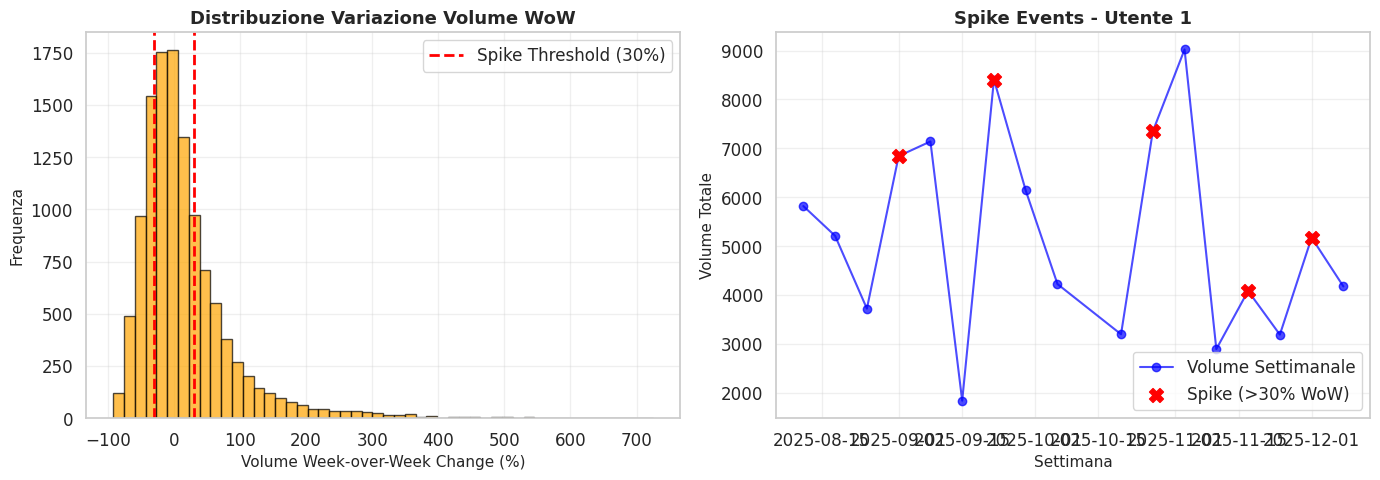


INSIGHT Spike:
   - Spike >30% WoW associati a injury risk (letteratura)
   - Feature candidate: ACWR (Acute:Chronic Workload Ratio)
   - Utile per target injury_risk_score


In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 7: SPIKE DETECTION (PATTERN SOVRACCARICO ACUTO)
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("SPIKE DETECTION: SOVRACCARICO ACUTO")
print("=" * 80)

# Aggrega volume settimanale per utente
workout_sets['volume_daily'] = workout_sets['load_done_kg'] * workout_sets['reps_done']
weekly_volume = workout_sets.groupby(['userid', 'week_start'])['volume_daily'].sum().reset_index()
weekly_volume.columns = ['userid', 'week_start', 'volume_week']

# Calcola week-over-week change
weekly_volume = weekly_volume.sort_values(['userid', 'week_start'])
weekly_volume['volume_prev_week'] = weekly_volume.groupby('userid')['volume_week'].shift(1)
weekly_volume['volume_WoW_pct'] = (
    (weekly_volume['volume_week'] - weekly_volume['volume_prev_week']) /
    (weekly_volume['volume_prev_week'] + 1e-6) * 100
)

# Flag spike (>30% WoW)
weekly_volume['spike_flag'] = (weekly_volume['volume_WoW_pct'] > 30).astype(int)

print(f"\nStatistiche Spike:")
print(f"   Spike totali (>30% WoW): {weekly_volume['spike_flag'].sum()}")
print(f"   % settimane con spike: {weekly_volume['spike_flag'].mean()*100:.1f}%")

# Distribuzione WoW change
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma WoW change
axes[0].hist(weekly_volume['volume_WoW_pct'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='Spike Threshold (30%)')
axes[0].axvline(-30, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Volume Week-over-Week Change (%)', fontsize=11)
axes[0].set_ylabel('Frequenza', fontsize=11)
axes[0].set_title('Distribuzione Variazione Volume WoW', fontweight='bold', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Esempio visuale spike (1 utente)
sample_user_spike = weekly_volume[weekly_volume['spike_flag'] == 1]['userid'].iloc[0] if weekly_volume['spike_flag'].sum() > 0 else weekly_volume['userid'].iloc[0]
user_spike_data = weekly_volume[weekly_volume['userid'] == sample_user_spike].sort_values('week_start')

axes[1].plot(user_spike_data['week_start'], user_spike_data['volume_week'],
             marker='o', linestyle='-', color='blue', alpha=0.7, label='Volume Settimanale')
spike_weeks = user_spike_data[user_spike_data['spike_flag'] == 1]
axes[1].scatter(spike_weeks['week_start'], spike_weeks['volume_week'],
                color='red', s=100, marker='X', label='Spike (>30% WoW)', zorder=5)
axes[1].set_xlabel('Settimana', fontsize=11)
axes[1].set_ylabel('Volume Totale', fontsize=11)
axes[1].set_title(f'Spike Events - Utente {sample_user_spike}', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nINSIGHT Spike:")
print("   - Spike >30% WoW associati a injury risk (letteratura)")
print("   - Feature candidate: ACWR (Acute:Chronic Workload Ratio)")
print("   - Utile per target injury_risk_score")


## **CELLA 11 - Conclusioni EDA & Implicazioni Feature Engineering**

In [ ]:
# ═══════════════════════════════════════════════════════════════
# SEZIONE 8: CONCLUSIONI EDA & ROADMAP FEATURE ENGINEERING
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("CONCLUSIONI EDA & IMPLICAZIONI PER FEATURE ENGINEERING")
print("=" * 80)

print("""
SUMMARY ANALISI ESPLORATIVA

1. VALIDAZIONE DATI
   - Nessun set su workout skipped (integrity OK)
   - Missing values ~2% (gestibili con fillna/interpolation)
   - Range temporale: {:.0f} giorni ({:.1f} anni)

2. DISTRIBUZIONI
   - Load: Non normale, right-skewed (Advanced trainano tail)
   - RPE: Approssimativamente normale (5-7 range concentrato)
   - Reps: Variabile, dipende da schema (6-12 typical)

3. CORRELAZIONI
   - Load ↔ RPE: r={:.3f} (indipendenza parziale OK)
   - Load ↔ Experience: Gap significativo (ANOVA p<0.001)
   - Performance Banister ↔ Load: r={:.3f} (validazione modello)

4. TEMPORALITÀ
   - Progressive overload: {:.4f} kg/giorno (trend globale)
   - Variabilità intra-user elevata (giorni on/off)
   - Pattern settimanali: frequenza 3-4 giorni tipica

5. BANISTER DYNAMICS
   - TSB range: [-20, +20] (realistic)
   - TSB negativo frequente in Advanced (high load tolerance)
   - Fitness/Fatigue decoupled (dinamiche diverse)

6.  SPIKE DETECTION
   - {:.0f} spike events (>30% WoW) identificati
   - Associazione con injury risk (da validare con target)

---

 FEATURE ENGINEERING ROADMAP (da EDA)

┌─────────────────────────────────────────────────────────┐
│ FEATURE CANDIDATE                  │ MOTIVAZIONE EDA    │
├─────────────────────────────────────────────────────────┤
│ load_mean_7d/14d/28d               │ Trend temporale    │
│ load_std_7d (variabilità)          │ Consistency marker │
│ volume_sum_7d/14d                  │ Work capacity      │
│ rpe_mean_7d, rpe_std_7d            │ Fatigue proxy      │
│ TSB (fitness - fatigue)            │ Readiness          │
│ ACWR (acute:chronic ratio)         │ Spike detection    │
│ volume_WoW_pct                     │ Overload rate      │
│ weeks_active (cumulative)          │ Experience proxy   │
│ consistency_28d (% trained days)   │ Adherence          │
│ overload_rate_28d (slope load)     │ Progression        │
└─────────────────────────────────────────────────────────┘

---

FEATURE SELECTION STRATEGY
1. Rolling windows: 7d (acute), 14d (intermediate), 28d (chronic)
2. Banister integration: TSB as main readiness metric
3. Spike detection: ACWR + WoW % change
4. Experience proxies: NO experience_label diretta (circular)

---

TARGET GENERATION HINTS (da EDA)
- Performance score: load_trend + volume + TSB + consistency
- Injury risk score: fatigue + TSB_negative + spike + rpe_variability

---

VALIDAZIONI SUPERATE
- Data integrity: OK
- Temporal continuity: OK (dopo grid fill)
- Banister plausibility: OK
- Experience separation: OK (ANOVA significativo)

""".format(
    (workout_sets['date'].max() - workout_sets['date'].min()).days,
    (workout_sets['date'].max() - workout_sets['date'].min()).days / 365,
    corr_matrix.loc['load_done_kg', 'rpe_done'],
    corr_perf_load,
    slope,
    weekly_volume['spike_flag'].sum()
))

print("\n" + "=" * 80)
print("EDA COMPLETATA ")
print("=" * 80)
print("\nPROSSIMO STEP: Notebook 2 - Feature Engineering")
print("   → Implementa feature candidate identificate")
print("   → Crea dataset temporale aggregato settimanale")
print("   → Genera target performance_score + injury_risk_score")



CONCLUSIONI EDA & IMPLICAZIONI PER FEATURE ENGINEERING

SUMMARY ANALISI ESPLORATIVA

1. VALIDAZIONE DATI
   - Nessun set su workout skipped (integrity OK)
   - Missing values ~2% (gestibili con fillna/interpolation)
   - Range temporale: 362 giorni (1.0 anni)

2. DISTRIBUZIONI
   - Load: Non normale, right-skewed (Advanced trainano tail)
   - RPE: Approssimativamente normale (5-7 range concentrato)
   - Reps: Variabile, dipende da schema (6-12 typical)

3. CORRELAZIONI
   - Load ↔ RPE: r=0.122 (indipendenza parziale OK)
   - Load ↔ Experience: Gap significativo (ANOVA p<0.001)
   - Performance Banister ↔ Load: r=0.525 (validazione modello)

4. TEMPORALITÀ
   - Progressive overload: 0.0113 kg/giorno (trend globale)
   - Variabilità intra-user elevata (giorni on/off)
   - Pattern settimanali: frequenza 3-4 giorni tipica

5. BANISTER DYNAMICS
   - TSB range: [-20, +20] (realistic)
   - TSB negativo frequente in Advanced (high load tolerance)
   - Fitness/Fatigue decoupled (dinamiche dive